In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/hpathak/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
epochs =1 #change the number
batch_size=200
learning_rate = 0.001
pr_type = 32
max_pool = True
if pr_type == 32:
    dType = tf.float32
else:
    dType = tf.float16

### CNN AUTOENCODER NO NORM

In [ ]:

tf.reset_default_graph()
g1 = tf.Graph()

with g1.as_default():
    # Input and target placeholders
    inputs_ = tf.placeholder(dtype=dType, shape=(None, 28,28,1), name= 'inputs')
    targets_ = tf.placeholder(dtype=dType, shape=(None, 28,28,1) , name='targets')


    w1 = tf.get_variable(name='W1',shape=[3,3,1,16],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w2 = tf.get_variable(name='W2',shape=[3,3,16,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w3 = tf.get_variable(name='W3',shape=[3,3,8,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w4 = tf.get_variable(name='W4',shape=[3,3,8,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w5 = tf.get_variable(name='W5',shape=[3,3,8,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w6 = tf.get_variable(name='W6',shape=[3,3,8,16],dtype=dType,initializer=tf.contrib.layers.xavier_initializer()) 
    logit_w = tf.get_variable(name='logit_w',shape=[3,3,16,1],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    





    conv1 = tf.nn.conv2d(input=inputs_,filter=w1,strides=[1,2,2,1], padding='SAME', name='conv1')
    conv1 = tf.nn.relu(conv1)
    


    max_pool1 = tf.nn.max_pool(value=conv1,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME', name='maxpool1')
    conv2 = tf.nn.conv2d(input=max_pool1, filter=w2, strides=[1,2,2,1], padding='SAME', name='conv2')
    conv2 = tf.nn.relu(conv2)
    
    max_pool2 = tf.nn.max_pool(value=conv2,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME', name='maxpool2')
    conv3 = tf.nn.conv2d(input=max_pool2, filter=w3, strides=[1,2,2,1], padding='SAME', name='conv3')
    conv3 = tf.nn.relu(conv3)

    encoded = tf.nn.max_pool(value=conv3, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='encoded')


    upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7,7), name='upsample1')
    conv4 = tf.nn.conv2d(input=upsample1, filter=w4,strides=[1,1,1,1] ,  padding='SAME', name='conv4')
    conv4 = tf.nn.relu(conv4)

    upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14,14), name='upsample2')
    conv5 = tf.nn.conv2d(input=upsample2, filter=w5,strides=[1,1,1,1], padding='SAME', name = 'conv5')
    conv5 = tf.nn.relu(conv5)

    upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28,28), name='upsample3')
    conv6 = tf.nn.conv2d(input=upsample3, filter=w6, strides=[1,1,1,1], padding='SAME', name='conv5')
    conv6 = tf.nn.relu(conv6)

    logits = tf.nn.conv2d(input=conv6, filter=logit_w,strides=[1,1,1,1] ,padding='SAME')

    decoded = tf.nn.sigmoid(logits,name='decoded')

    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
    cost = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()



### Weight Normalized Auto encoder
#### Only Weights - data independent


In [ ]:
def get_normed_weights(shape, axis=None, name=None, return_all=True,
                       reuse=None,
                       init=tf.random_normal_initializer(stddev=0.05)):
    """
    Returns a normalised tensor of the given shape.
    Args:
      shape: the shape of the desired weights. At the moment we assume
        this is [num_inputs x num_outputs] and we have a gain/scale per
        output.
      axis: the axis or axes over which to normalise. If None (default), then
        each element is divided by the norm of the entire tensor.
      scope: scope in which to get the variables required. Defaults to None,
        which means `weightnorm` will be used.
      return_all: if true, returns the allocated trainable variable as well as
        the resulting weights.
      reuse: whether or not to attempt to reuse variables. Default is False.
      init: the initializer to use to initialise the variables. Defaults to the
        values from the paper, ie. normally distributed with mean 0 and
        standard deviation 0.05.
    Returns:
      - if `return_all` is true it will return `(w, g, v)` where `w` is the
          required weights, `g` and `v` are the scale and the unnormalised
          weights respectively.
      - otherwise, just return `w`.
    """
    v = tf.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=init)
    g = tf.get_variable(name=name+'g', shape=shape[-1], initializer=tf.constant_initializer(1),trainable=False)
    
    inv_norm = tf.rsqrt(tf.reduce_sum(tf.square(v), reduction_indices=axis))
    w = v * g * inv_norm
    return w


In [ ]:
learning_rate = 0.001
pr_type = 32
max_pool = True

if pr_type == 32:
    dType = tf.float32
else:
    dType = tf.float16

tf.reset_default_graph()
g2 = tf.Graph()


with g2.as_default():
    # Input and target placeholders
    inputs_ = tf.placeholder(dtype=dType, shape=(None, 28,28,1), name= 'inputs')
    targets_ = tf.placeholder(dtype=dType, shape=(None, 28,28,1) , name='targets')


    #w1 = tf.get_variable(name='W1',shape=,dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w1 = get_normed_weights(shape=[3,3,1,16], axis=[0,1,2],name='W1', init=tf.contrib.layers.xavier_initializer())
    
    #w2 = tf.get_variable(name='W2',shape=[3,3,16,8],dtype=dType,)    
    w2 = get_normed_weights(shape=[3,3,16,8], axis=[0,1,2],name='W2', init=tf.contrib.layers.xavier_initializer())
    
    #w3 = tf.get_variable(name='W3',shape=[3,3,8,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w3 = get_normed_weights(shape=[3,3,8,8], axis=[0,1,2],name='W3', init=tf.contrib.layers.xavier_initializer())
    
    #w4 = tf.get_variable(name='W4',shape=[3,3,8,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w4 = get_normed_weights(shape=[3,3,8,8], axis=[0,1,2],name='W4', init=tf.contrib.layers.xavier_initializer())
    
    #w5 = tf.get_variable(name='W5',shape=[3,3,8,8],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    
    w5 = get_normed_weights(shape=[3,3,8,8], axis=[0,1,2],name='W5', init=tf.contrib.layers.xavier_initializer())
    
    #w6 = tf.get_variable(name='W6',shape=[3,3,8,16],dtype=dType,initializer=tf.contrib.layers.xavier_initializer()) 
    w6 = get_normed_weights(shape=[3,3,8,16], axis=[0,1,2],name='W6', init=tf.contrib.layers.xavier_initializer())
    
    logit_w = tf.get_variable(name='logit_w',shape=[3,3,16,1],dtype=dType,initializer=tf.contrib.layers.xavier_initializer())    





    conv1 = tf.nn.conv2d(input=inputs_,filter=w1,strides=[1,2,2,1], padding='SAME', name='conv1')
    
    #conv1 = wnconv(x=inputs_, filter_size=[3,3,1,16], strides=[1,2,2,1], padding="SAME", name='conv1', init=True)
    conv1 = tf.nn.relu(conv1)
    


    max_pool1 = tf.nn.max_pool(value=conv1,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME', name='maxpool1')
    conv2 = tf.nn.conv2d(input=max_pool1, filter=w2, strides=[1,2,2,1], padding='SAME', name='conv2')
    conv2 = tf.nn.relu(conv2)
    
    max_pool2 = tf.nn.max_pool(value=conv2,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME', name='maxpool2')
    conv3 = tf.nn.conv2d(input=max_pool2, filter=w3, strides=[1,2,2,1], padding='SAME', name='conv3')
    conv3 = tf.nn.relu(conv3)

    encoded = tf.nn.max_pool(value=conv3, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='encoded')


    upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7,7), name='upsample1')
    conv4 = tf.nn.conv2d(input=upsample1, filter=w4,strides=[1,1,1,1] ,  padding='SAME', name='conv4')
    conv4 = tf.nn.relu(conv4)

    upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14,14), name='upsample2')
    conv5 = tf.nn.conv2d(input=upsample2, filter=w5,strides=[1,1,1,1], padding='SAME', name = 'conv5')
    conv5 = tf.nn.relu(conv5)

    upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28,28), name='upsample3')
    conv6 = tf.nn.conv2d(input=upsample3, filter=w6, strides=[1,1,1,1], padding='SAME', name='conv5')
    conv6 = tf.nn.relu(conv6)

    logits = tf.nn.conv2d(input=conv6, filter=logit_w,strides=[1,1,1,1] ,padding='SAME')

    decoded = tf.nn.sigmoid(logits,name='decoded')

    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
    cost = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()




#### Data Dependet Parameter initialization

In [24]:
# def get_var_maybe_avg(var_name, ema, **kwargs):
#     ''' utility for retrieving polyak averaged params '''
#     v = tf.get_variable(var_name, **kwargs)
#     if ema is not None:
#         v = ema.average(v)
#     return v

# def get_vars_maybe_avg(var_names, ema, **kwargs):
#     ''' utility for retrieving polyak averaged params '''
#     vars = []
#     for vn in var_names:
#         vars.append(get_var_maybe_avg(vn, ema, **kwargs))
#     return vars

# def get_name(layer_name, counters):
#     ''' utlity for keeping track of layer names '''
#     if not layer_name in counters:
#         counters[layer_name] = 0
#     name = layer_name + '_' + str(counters[layer_name])
#     counters[layer_name] += 1
#     return name
#
#input=inputs_,filter=w1,strides=[1,2,2,1], padding='SAME', name='conv1'
#
def wnconv2d(x, filter_size, name ,strides=[1,2,2,1], padding='SAME', init_scale=1.0, init=True):
    ''' convolutional layer '''
    #name = get_name('conv2d', counters)
    with tf.variable_scope(name):
        if init:
            # data based initialization of parameters
            V = tf.get_variable(name=name, shape=filter_size, dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
            V_norm = tf.nn.l2_normalize(x=V.initialized_value(),axis=[0,1,2])
            x_init = tf.nn.conv2d(input=x, filter=V_norm,strides=strides , padding=padding)
            m_init, v_init = tf.nn.moments(x_init, [0,1,2])
            scale_init = init_scale/tf.sqrt(v_init + 1e-8)
            
            #g = tf.get_variable(name+'g', dtype=tf.float32, initializer=scale_init, trainable=True)
            #b = tf.get_variable(name+'b', dtype=tf.float32, initializer=-m_init*scale_init, trainable=True)
            
            x_init = tf.reshape(scale_init,[1,1,1,filter_size[-1]])*(x_init-tf.reshape(m_init,[1,1,1,filter_size[-1]]))
            return tf.cast(x_init, tf.float32)

#         else:
#             V, g, b = get_vars_maybe_avg(['V', 'g', 'b'], ema)
#             tf.assert_variables_initialized([V,g,b])

#             # use weight normalization (Salimans & Kingma, 2016)
#             W = tf.reshape(g,[1,1,1,num_filters])*tf.nn.l2_normalize(V,[0,1,2])

#             # calculate convolutional layer output
#             x = tf.nn.bias_add(tf.nn.conv2d(x, W, [1]+stride+[1], pad), b)

        
#             return x


In [25]:


g3 = tf.Graph()


with g3.as_default():
    # Input and target placeholders
    
    inputs_ = tf.placeholder(dtype=tf.float32, shape=(None,28,28,1), name='inputs_')
    targets_ = tf.placeholder(dtype=tf.float32, shape=(None, 28,28,1) , name='targets_')


    logit_w = tf.get_variable(name='logit_w',shape=[3,3,16,1],dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer())    


    
    conv1 = wnconv2d(x=inputs_, filter_size=[3,3,1,16], name='conv1',strides=[1,2,2,1], padding="SAME",  init=True)
    conv1 = tf.nn.relu(conv1)
    
    max_pool1 = tf.nn.max_pool(value=conv1,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME', name='maxpool1')
    conv2 = wnconv2d(x=max_pool1, filter_size=[3,3,16,8], name='conv2',strides=[1,2,2,1], padding="SAME",  init=True)
    conv2 = tf.nn.relu(conv2)
    
    max_pool2 = tf.nn.max_pool(value=conv2,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME', name='maxpool2')
    conv3 = wnconv2d(x=max_pool2, filter_size=[3,3,8,8], name='conv3',strides=[1,2,2,1], padding="SAME",  init=True)
    conv3 = tf.nn.relu(conv3)

    encoded = tf.nn.max_pool(value=conv3, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='encoded')


    upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7,7), name='upsample1')
    conv4 = wnconv2d(x=encoded, filter_size=[3,3,8,8], name='conv4',strides=[1,2,2,1], padding="SAME",  init=True)
    conv4 = tf.nn.relu(conv4)

    upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14,14), name='upsample2')
    conv5 = wnconv2d(x=upsample2, filter_size=[3,3,8,8], name='conv5',strides=[1,1,1,1], padding="SAME",  init=True)
    conv5 = tf.nn.relu(conv5)

    upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28,28), name='upsample3')
    conv6 = wnconv2d(x=upsample3, filter_size=[3,3,8,16], name='conv6',strides=[1,1,1,1], padding="SAME",  init=True)
    conv6 = tf.nn.relu(conv6)

    logits = tf.nn.conv2d(input=conv6, filter=logit_w,strides=[1,1,1,1] ,padding='SAME', name='logits')

    decoded = tf.nn.sigmoid(logits,name='decoded')

    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
    cost = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init_ = tf.global_variables_initializer()





In [26]:
tf.reset_default_graph()
sess = tf.Session(graph=g3)

In [29]:
%%time
epochs =5
batch_size=200
sess.run(init_)


for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs ,targets_: imgs})
        if (ii % 50) ==0 :
            print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/5... Training loss: 0.8073
Epoch: 1/5... Training loss: 0.3477
Epoch: 1/5... Training loss: 0.3198
Epoch: 1/5... Training loss: 0.3126
Epoch: 1/5... Training loss: 0.3012
Epoch: 1/5... Training loss: 0.2999
Epoch: 2/5... Training loss: 0.3038
Epoch: 2/5... Training loss: 0.3024
Epoch: 2/5... Training loss: 0.2904
Epoch: 2/5... Training loss: 0.2923
Epoch: 2/5... Training loss: 0.2996
Epoch: 2/5... Training loss: 0.2960
Epoch: 3/5... Training loss: 0.2925
Epoch: 3/5... Training loss: 0.2936
Epoch: 3/5... Training loss: 0.2981
Epoch: 3/5... Training loss: 0.2883
Epoch: 3/5... Training loss: 0.2964
Epoch: 3/5... Training loss: 0.2977
Epoch: 4/5... Training loss: 0.2936
Epoch: 4/5... Training loss: 0.2924
Epoch: 4/5... Training loss: 0.2959
Epoch: 4/5... Training loss: 0.2956
Epoch: 4/5... Training loss: 0.2966
Epoch: 4/5... Training loss: 0.2912
Epoch: 5/5... Training loss: 0.2952
Epoch: 5/5... Training loss: 0.2934
Epoch: 5/5... Training loss: 0.2919
Epoch: 5/5... Training loss:

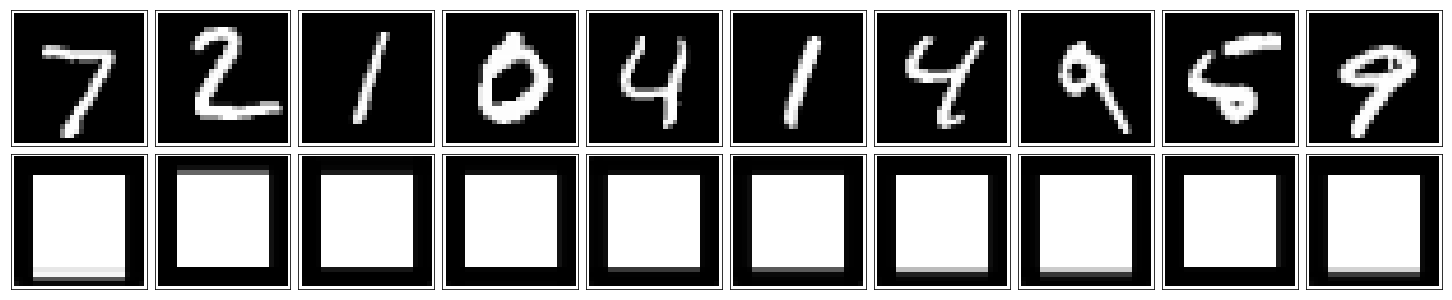

In [30]:

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [9]:
tf.__version__


'1.8.0'

### Benchmarking

| Initializer | optimizer |presion type | epochs | Wall time | loss | Norm
|---|---|---|---|
|xavier|ADAM|float32|5 epochs|5.50 mins| 0.2372 | No
|xavier|ADAM|float32|5 epochs|5.55 mins| 0.2350 | weight
|xavier|ADAM|float32|5 epochs|6.22 mins| 0.2850 | wn data dependent

